# Samples

In [1]:
import json
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import os
from roadrunner import RoadRunner

import sim_lib
from stochastic_models import biomodels_6615119181

t_fin = 6000.
# num_steps = 101
num_steps = 1001
res_step = 1
sample_size = 1000
var_names = ['MAPK', 'MAPK_P', 'MAPK_PP', 'MKK', 'MKKK', 'MKKK_P', 'MKK_P', 'MKK_PP']

# export_dir = None
export_dir = 'summary_figure'

def make_rr():
    return sim_lib.make_rr(RoadRunner.getParamPromotedSBML(biomodels_6615119181().sbml), True)

def extract_rr_time(_res):
    return _res[:, _res.colnames.index('time')]

def extract_rr_results(_res, _var_name: str):
    return _res[:, _res.colnames.index(f'[{_var_name}]')]

In [2]:
if export_dir is not None and not os.path.isdir(export_dir):
    os.makedirs(export_dir)

exported_exts = ['.jpg', '.png', '.svg']

def export_all(_fig, _fbname):
    if export_dir is not None:
        [_fig.savefig(os.path.join(export_dir, _fbname + ext)) for ext in exported_exts]

In [3]:
if sim_lib.get_pool() is None:
    sim_lib.start_pool()

rr = make_rr()
exec_args = sample_size, rr, t_fin, num_steps, True
res_rr1 = np.asarray(sim_lib.exec_rr_batch(*exec_args))
res_rr2 = np.asarray(sim_lib.exec_rr_batch(*exec_args))

In [4]:
var_name = var_names[0]

res_time = res_rr1[0, :, 0]
res_var1 = res_rr1[:, :, var_names.index(var_name)+1].T
res_var2 = res_rr2[:, :, var_names.index(var_name)+1].T

In [5]:
fig_dim = 1

mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.grid.which'] = 'major'
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 6.0
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.borderaxespad'] = 0.2
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.fontsize'] = 6.0
plt.rcParams['legend.handlelength'] = 1.0
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.3
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 1

# Trajectories

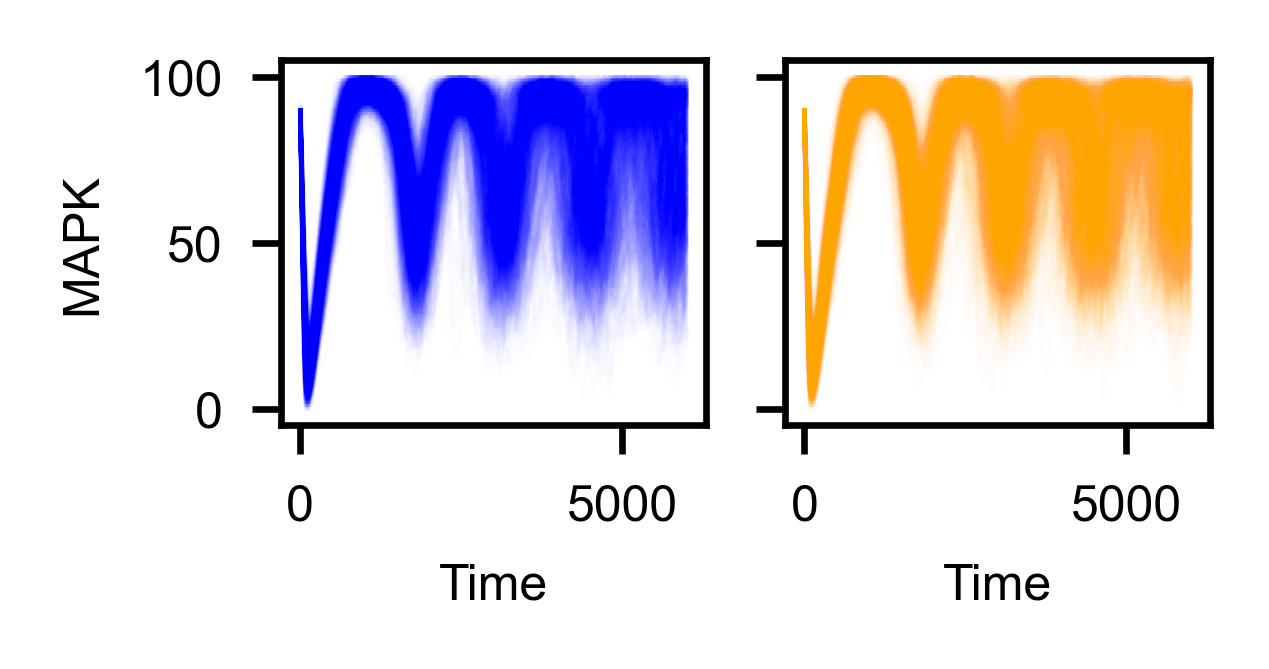

In [6]:
plot_kwargs = dict(
    alpha=0.01
)
color1 = 'blue'
color2 = 'orange'

fig, axs = plt.subplots(1, 2, 
                        layout='compressed',
                        figsize=(fig_dim * 2, fig_dim),
                        sharey=True
                        )

res_var_all = [res_var1, res_var2]
color_all = [color1, color2]

for ax, res, color in zip(axs, res_var_all, color_all):
    ax.plot(res_time, res, color=color, **plot_kwargs)
    ax.set_xlabel('Time')
axs[0].set_ylabel(var_name)

export_all(fig, 'trajectories')

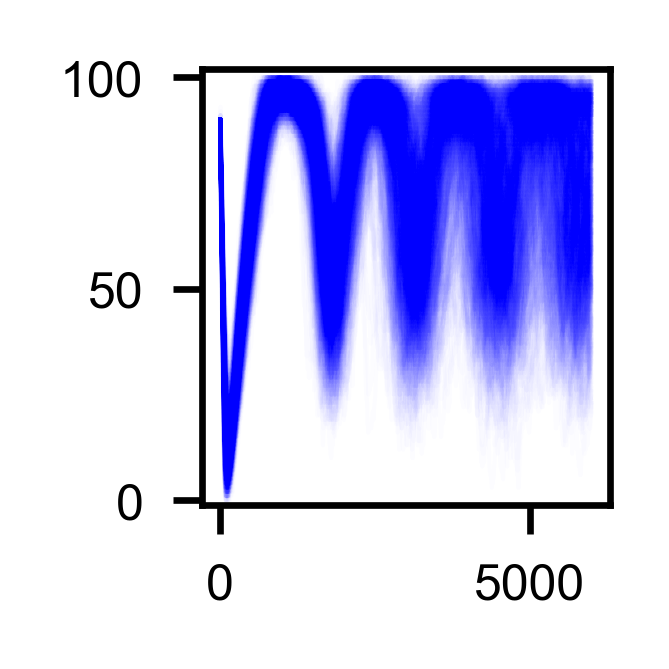

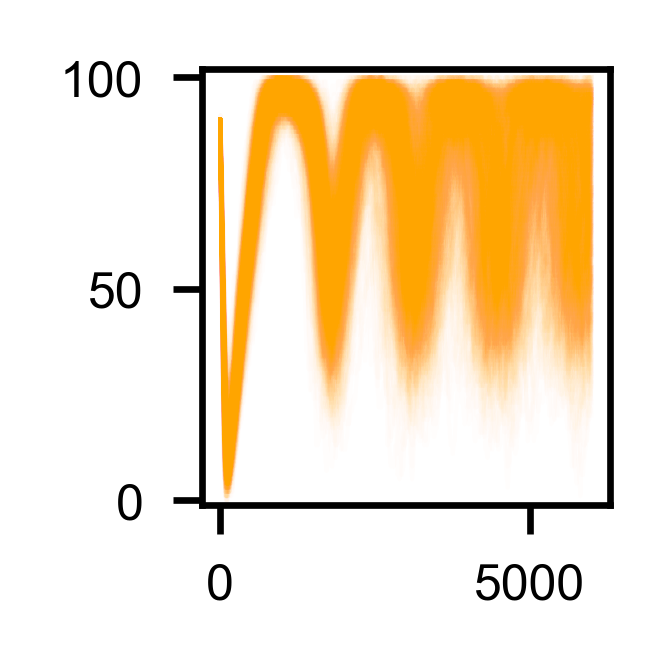

In [7]:
res_var_all = [res_var1, res_var2]
color_all = [color1, color2]

for i, (res, color) in enumerate(zip(res_var_all, color_all)):
    fig, ax = plt.subplots(1, 1, layout='compressed', figsize=(fig_dim, fig_dim))
    ax.plot(res_time, res, color=color, **plot_kwargs)
    ax.set_ylim(-1, 102)
    
    export_all(fig, f'trajectories_plain_{i}')

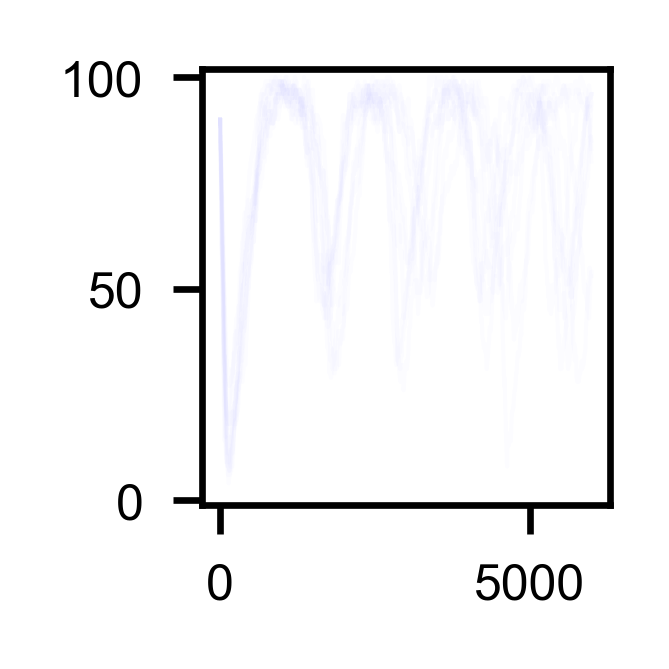

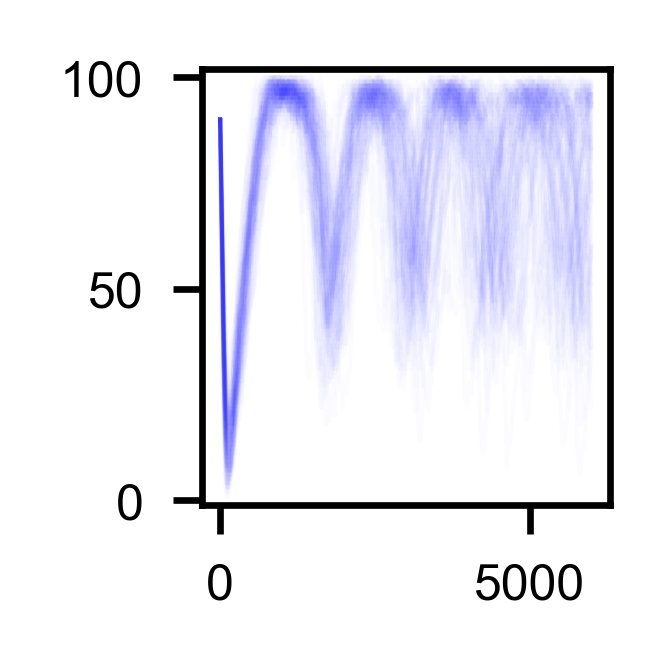

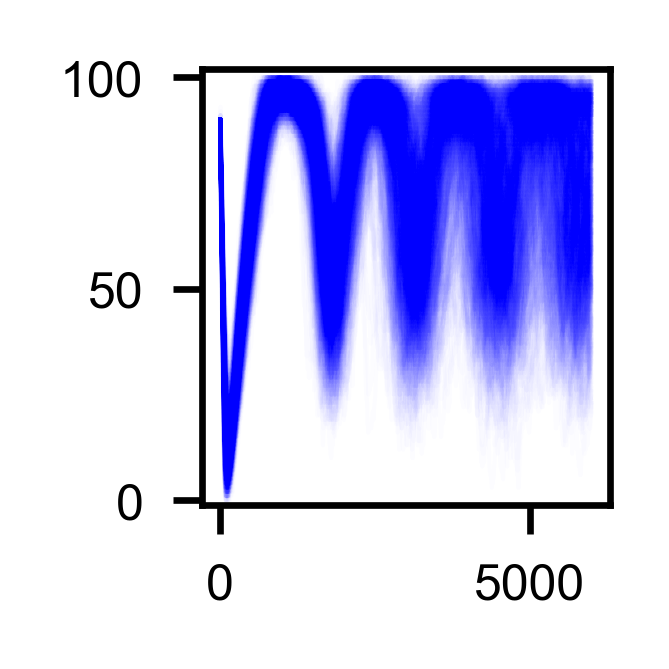

In [8]:
# Show one set with 10, 100, and 1K trajectories

for n in [10, 100, 1000]:
    fig, ax = plt.subplots(1, 1, layout='compressed', figsize=(fig_dim, fig_dim))
    ax.plot(res_time, res_var_all[0][:, :n], color=color_all[0], **plot_kwargs)
    ax.set_ylim(-1, 102)
    
    export_all(fig, f'trajectories_plain_0_{n}')

# Heatmap

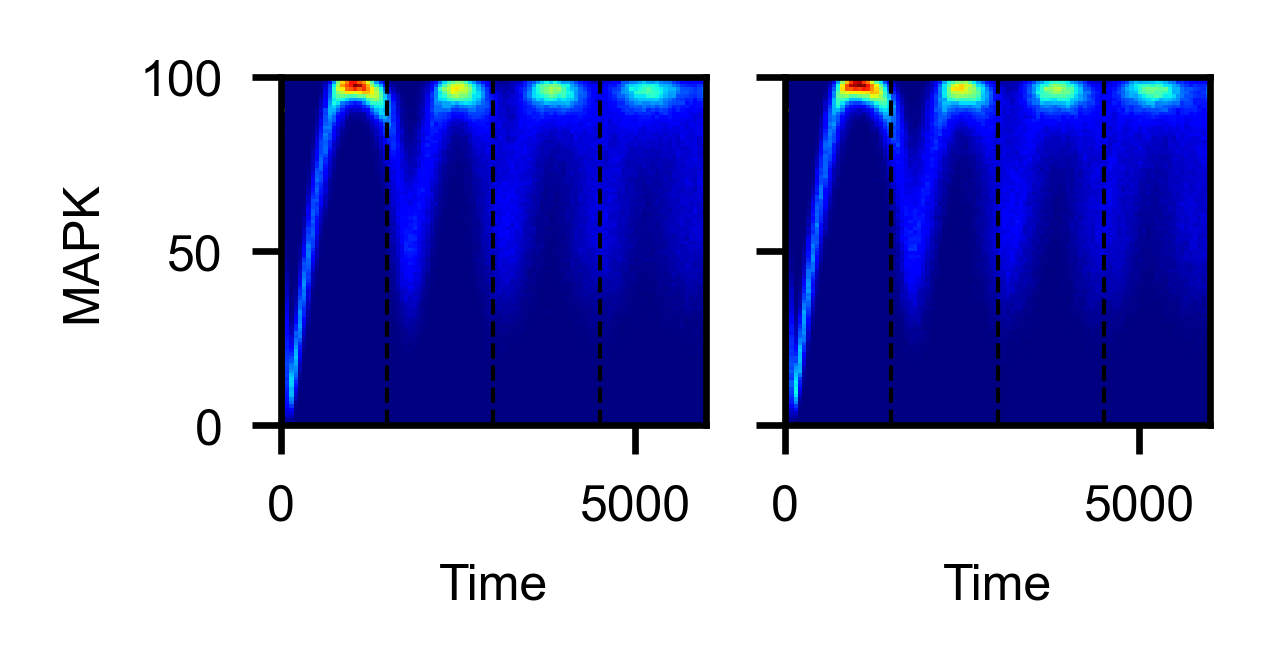

In [9]:
time_oi_idx = 500
times_others_idx = [250, 750]
time_oi = res_time[time_oi_idx]
times_others = res_time[times_others_idx]

cmap_blue = ListedColormap(np.linspace(to_rgba('white'), to_rgba('blue'), 256))
cmap_orange = ListedColormap(np.linspace(to_rgba('white'), to_rgba('orange'), 256))

# cmaps = ['Blues', 'Oranges']
# cmaps = [cmap_blue, cmap_orange]
# cmaps = ['jet', 'jet']

cmap_custom = plt.get_cmap('jet')
cmap_custom = cmap_custom(np.linspace(0, 1, cmap_custom.N))
# cmap_custom[0] = [1.0, 1.0, 1.0, 1.0]
cmap_custom = ListedColormap(cmap_custom)
cmaps = [cmap_custom, cmap_custom]


fig, axs = plt.subplots(1, 2, 
                        layout='compressed',
                        figsize=(fig_dim * 2, fig_dim),
                        sharey=True
                        )

cfs = []
for ax, res, cmap in zip(axs, res_var_all, cmaps):
    cfs.append(ax.hist2d(np.repeat(res_time, res.shape[1]), res.flatten(), bins=100, 
                         # vmax=1000.,
                         cmap=cmap
                         # cmap='jet'
                         )[3])
    ax.axvline(time_oi, linestyle='--', color='black')
    [ax.axvline(t, linestyle='--', color='black') for t in times_others]
    ax.set_xlabel('Time')
    ax.grid(False)
axs[0].set_ylabel(var_name)

export_all(fig, 'heatmap')

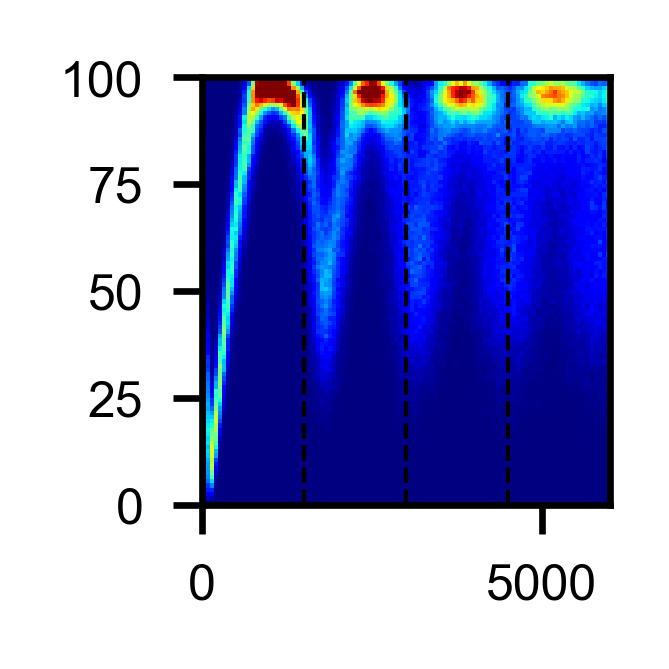

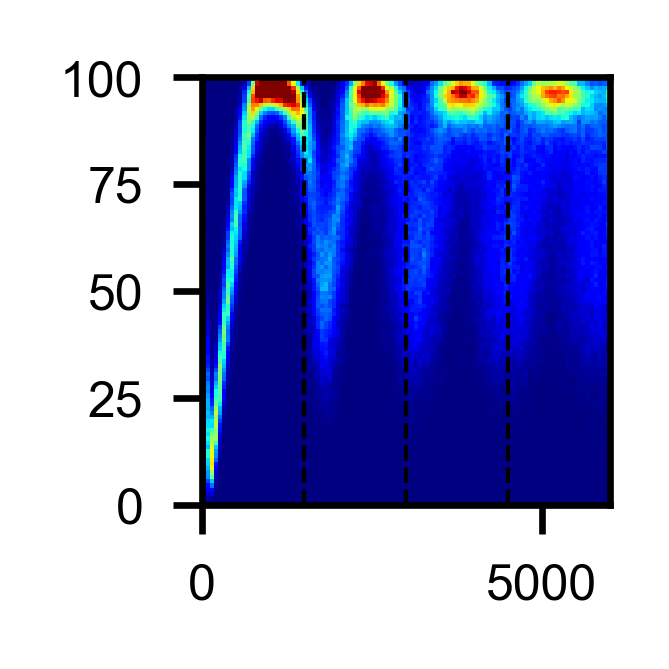

In [10]:
for i, (res, cmap) in enumerate(zip(res_var_all, cmaps)):
    fig, ax = plt.subplots(1, layout='compressed', figsize=(fig_dim, fig_dim))
    ax.hist2d(np.repeat(res_time, res.shape[1]), res.flatten(), bins=100, vmax=1000., cmap=cmap)
    ax.axvline(time_oi, linestyle='--', color='black')
    [ax.axvline(t, linestyle='--', color='black') for t in times_others]
    ax.grid(False)

    export_all(fig, f'heatmap_{i}')

# 2D probability plot

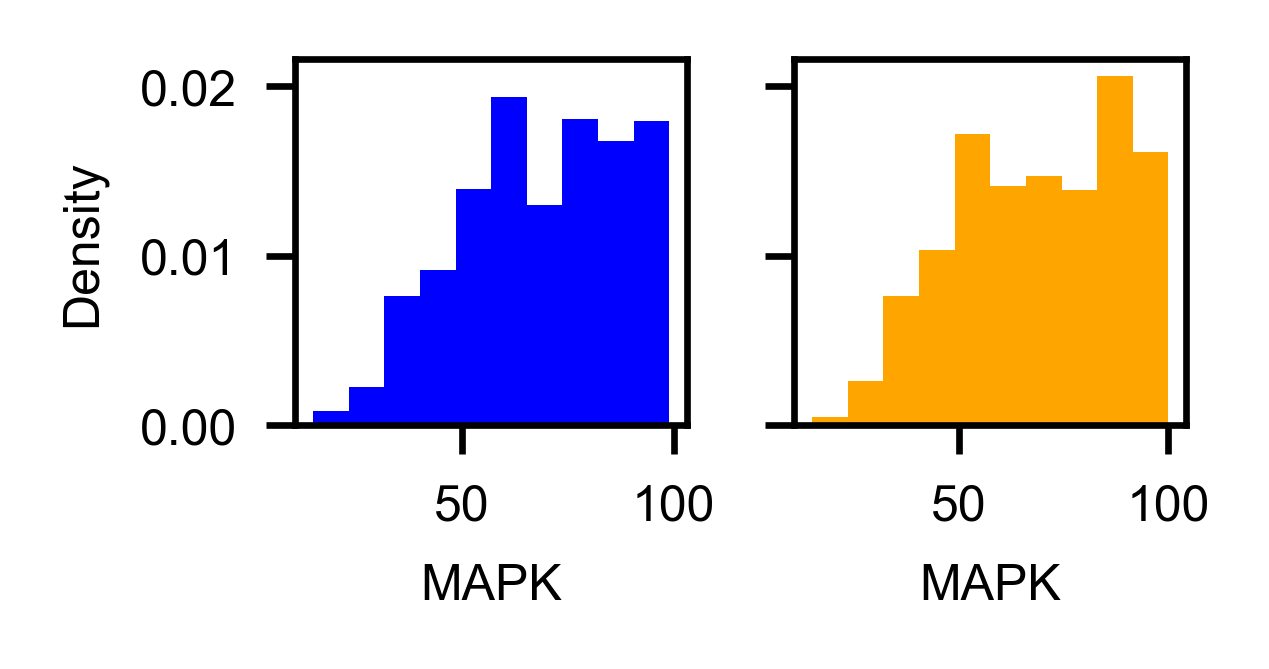

In [11]:
dist1 = res_var1[time_oi_idx+1, :]
dist2 = res_var2[time_oi_idx+1, :]

dist_all = [dist1, dist2]

fig, axs = plt.subplots(1, 2, 
                        layout='compressed',
                        figsize=(fig_dim * 2, fig_dim),
                        sharey=True
                        )

for ax, dist, color in zip(axs, dist_all, color_all):
    ax.hist(dist, density=True, color=color)
    ax.set_xlabel(var_name)
    ax.grid(False)
axs[0].set_ylabel('Density')

export_all(fig, 'densities')

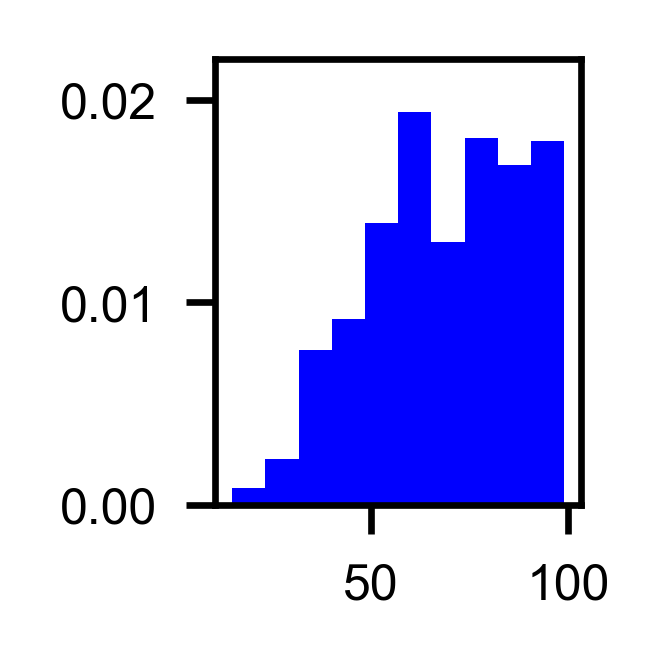

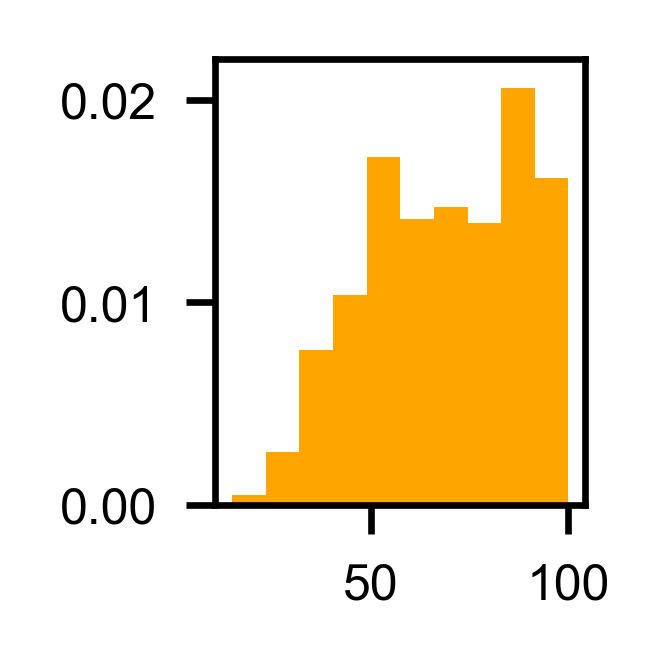

In [12]:
for i, (dist, color) in enumerate(zip(dist_all, color_all)):
    fig, ax = plt.subplots(1, 1, layout='compressed', figsize=(fig_dim, fig_dim))
    ax.hist(dist, density=True, color=color)
    ax.grid(False)
    ax.set_ylim(0, 0.022)

    export_all(fig, f'densities_plain_{i}')

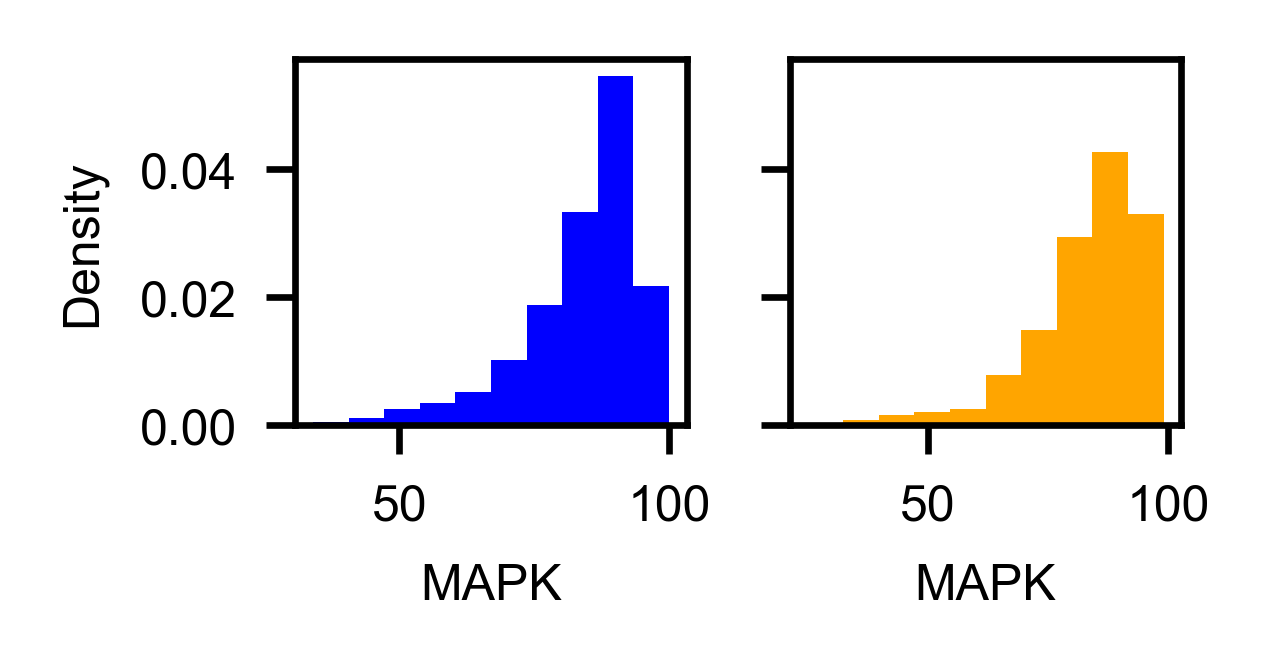

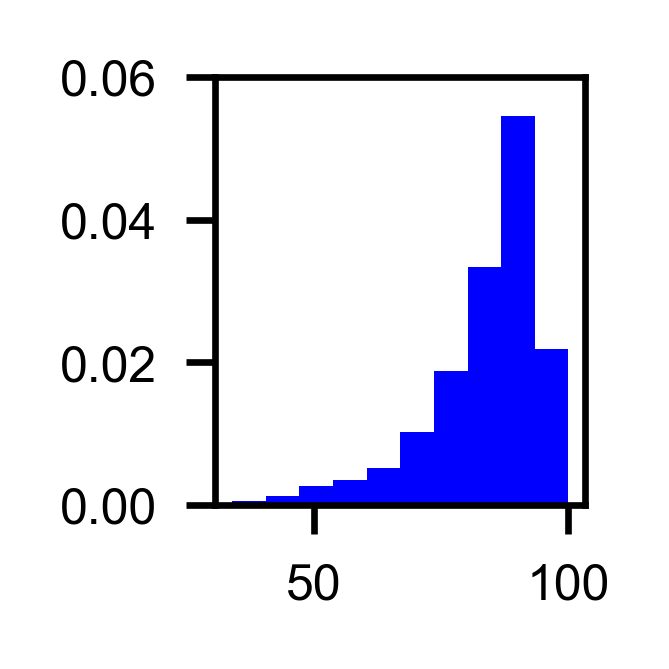

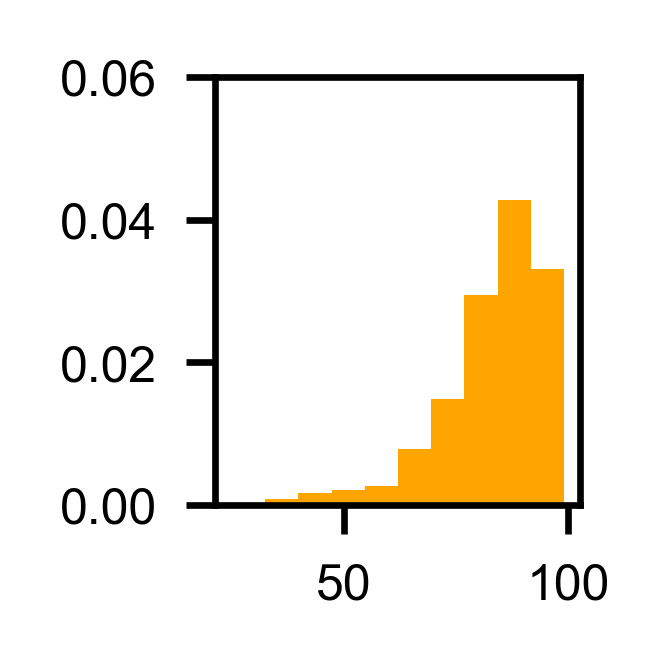

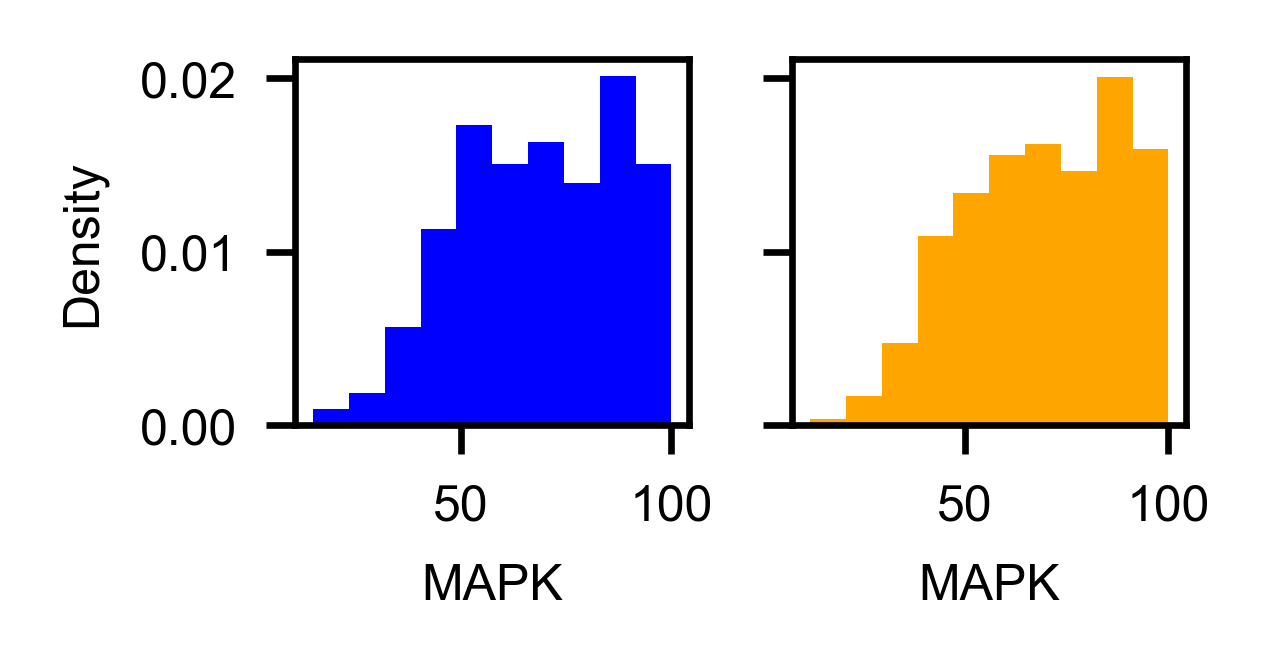

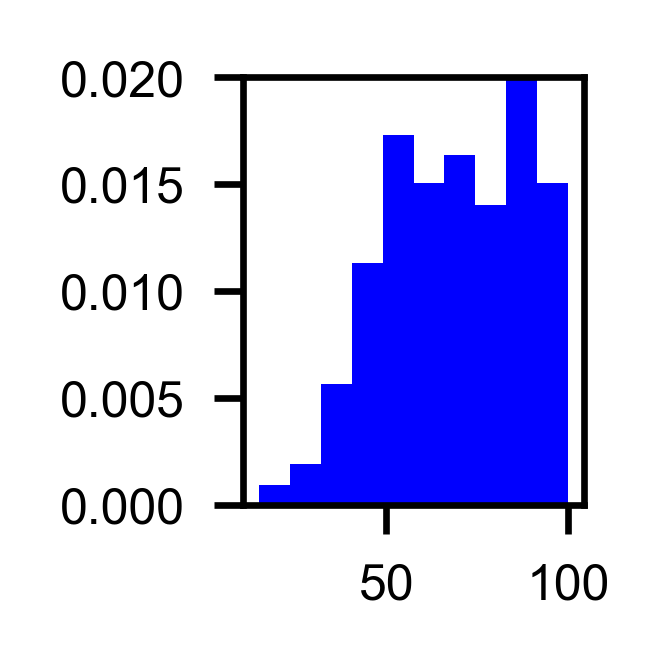

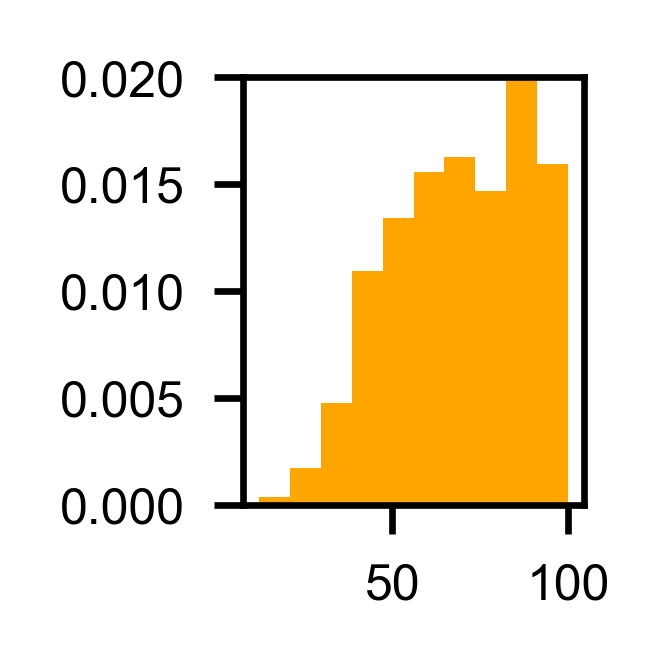

In [13]:
ylims_other = [0.06, 0.02]

for i, idx in enumerate(times_others_idx):

    dist1_other = res_var1[idx+1, :]
    dist2_other = res_var2[idx+1, :]

    dist_all_other = [dist1_other, dist2_other]

    fig, axs = plt.subplots(1, 2, 
                            layout='compressed',
                            figsize=(fig_dim * 2, fig_dim),
                            sharey=True
                            )

    for ax, dist, color in zip(axs, dist_all_other, color_all):
        ax.hist(dist, density=True, color=color)
        ax.set_xlabel(var_name)
        ax.grid(False)
    axs[0].set_ylabel('Density')

    export_all(fig, f'densities_other_{i}')

    for j, (dist, color) in enumerate(zip(dist_all_other, color_all)):
        fig, ax = plt.subplots(1, 1, layout='compressed', figsize=(fig_dim, fig_dim))
        ax.hist(dist, density=True, color=color)
        ax.grid(False)
        ax.set_ylim(0, ylims_other[i])

        export_all(fig, f'densities_other_{i}_plain_{j}')

# ECF plot

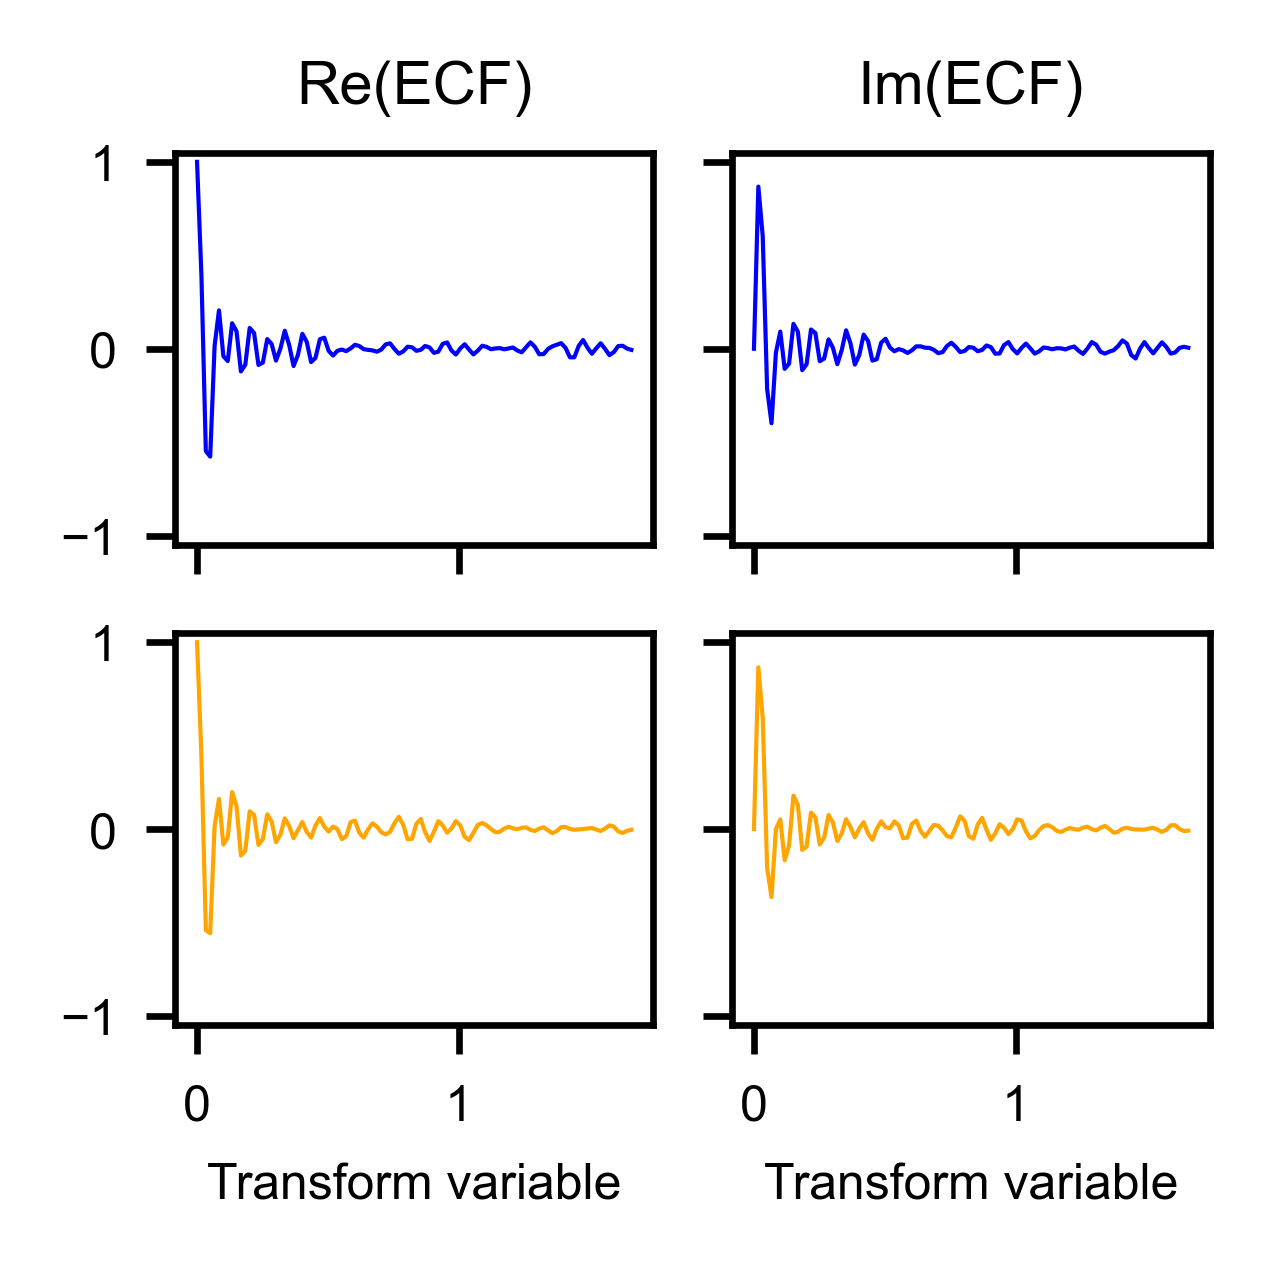

In [14]:
eval_num = 100
sig_figs = 12

def compute_ecfs(_dist1, _dist2):
    _dist1_std = np.std(_dist1)
    _eval_pts = sim_lib.get_eval_info_times(eval_num, 
                                            2 * sim_lib.DEF_NUM_VAR_PERS * np.pi / np.std(_dist1) if _dist1_std > 0.0 else 1.0)
    _ecf1 = sim_lib.ecf(_dist1, _eval_pts)
    _ecf2 = sim_lib.ecf(_dist2, _eval_pts)
    return _eval_pts, _ecf1, _ecf2

eval_pts, ecf1, ecf2 = compute_ecfs(dist1, dist2)

ecf_all = [ecf1, ecf2]

fig, axs = plt.subplots(2, 2, 
                        layout='compressed',
                        figsize=(fig_dim * 2, fig_dim * 2),
                        sharex=True,
                        sharey='row'
                        )

for i, ax in enumerate(axs):
    for j in range(2):
        axs[i][j].plot(eval_pts, ecf_all[i][:, j], color=color_all[i])
        axs[0][j].set_title(['Re(ECF)', 'Im(ECF)'][j])
    ax[0].set_ylim(-1.05, 1.05)
for j in range(2):
    axs[-1][j].set_xlabel('Transform variable')

export_all(fig, 'ecfs')

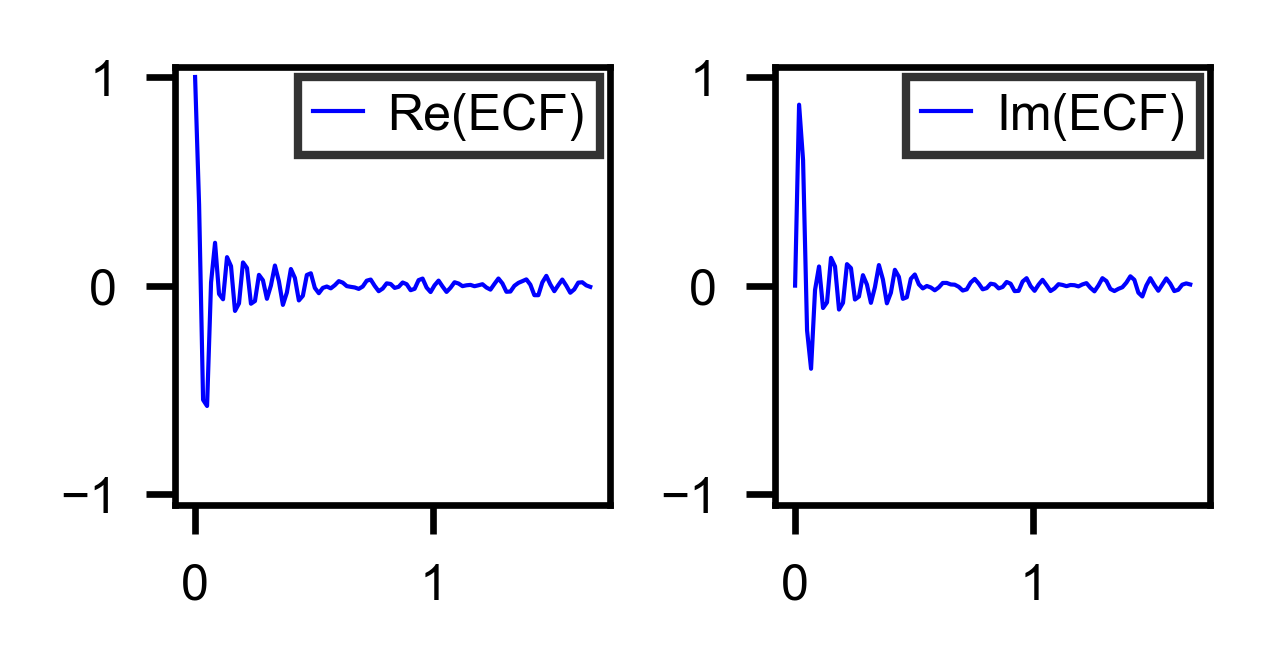

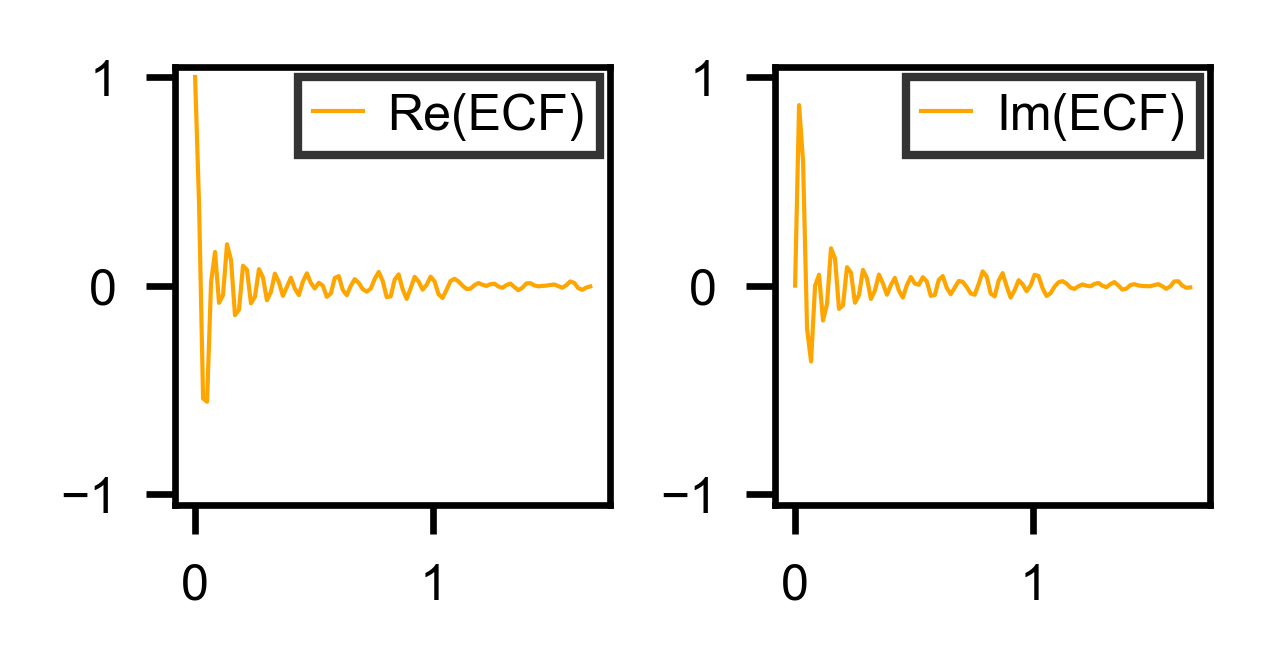

In [15]:
for i, (ecf, color) in enumerate(zip(ecf_all, color_all)):
    fig, axs = plt.subplots(1, 2, layout='compressed', figsize=(fig_dim * 2, fig_dim), sharex=True)
    for j in range(2):
        lab = ['Re(ECF)', 'Im(ECF)'][j]
        axs[j].plot(eval_pts, ecf[:, j], color=color, label=lab)
        axs[j].set_ylim(-1.05, 1.05)
        axs[j].legend()

    export_all(fig, f'ecfs_plain_{i}')

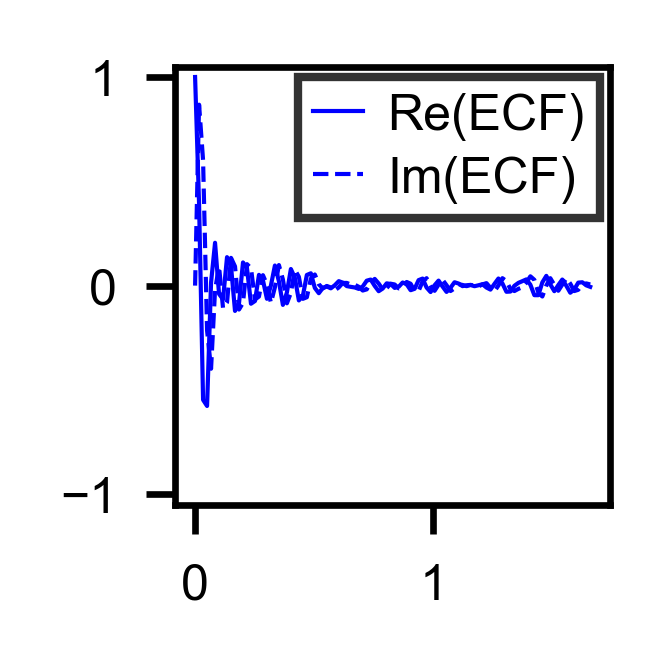

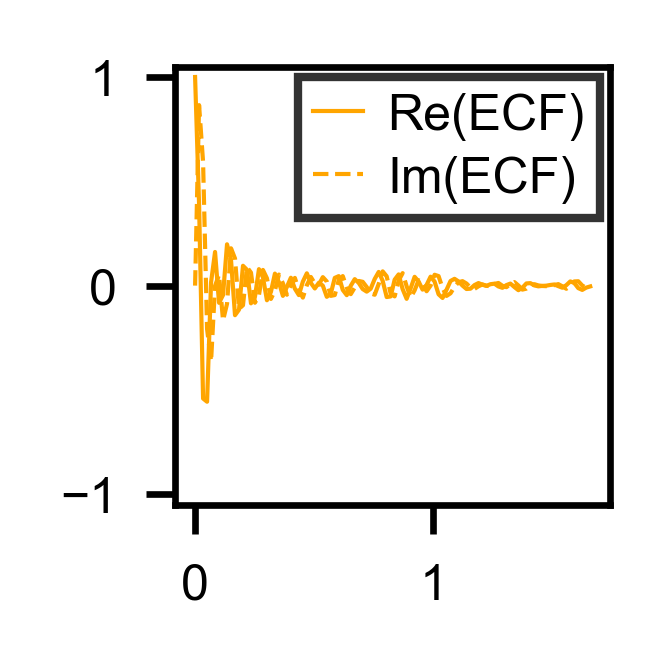

In [16]:
for i, (ecf, color) in enumerate(zip(ecf_all, color_all)):
    fig, ax = plt.subplots(1, 1, layout='compressed', figsize=(fig_dim, fig_dim), sharex=True)
    for j in range(2):
        lab = ['Re(ECF)', 'Im(ECF)'][j]
        linestyle = ['-', '--'][j]
        ax.plot(eval_pts, ecf[:, j], color=color, linestyle=linestyle, label=lab)
    ax.set_ylim(-1.05, 1.05)
    ax.legend()

    export_all(fig, f'ecfs_combined_plain_{i}')

# ECF comparison plot at a single time

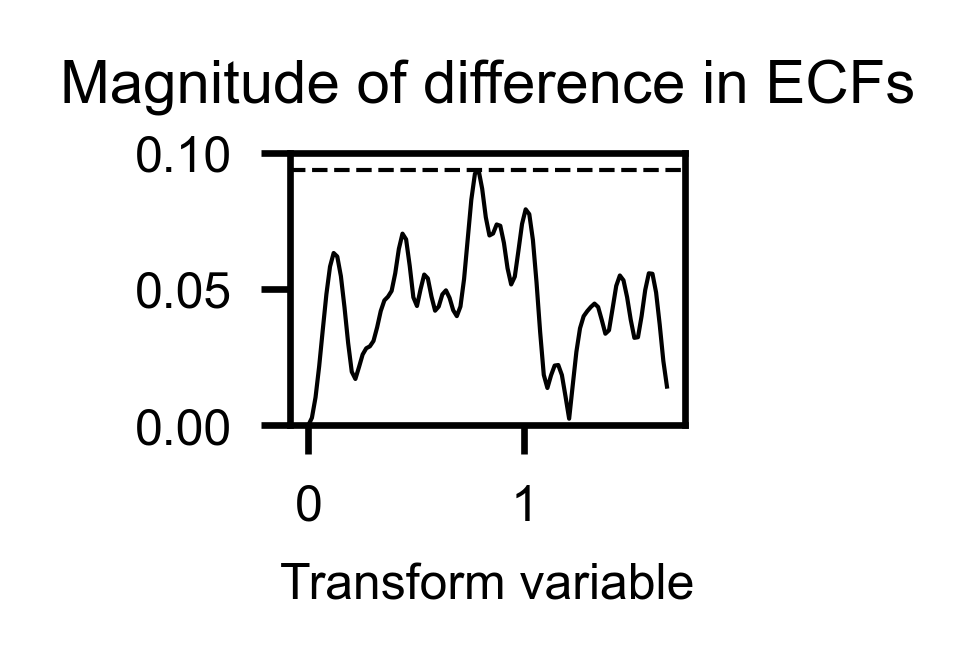

In [17]:
def compute_ecf_diff(_ecf1, _ecf2):
    return np.sqrt(np.sum(np.square(_ecf1 - _ecf2), axis=1))

ecf_diff = compute_ecf_diff(ecf1, ecf2)

fig, ax = plt.subplots(1, 1, 
                       layout='compressed',
                       figsize=(fig_dim, fig_dim)
                       )
ax.plot(eval_pts, ecf_diff, color='black')
ax.axhline(ecf_diff.max(), linestyle='--', color='black')
ax.set_xlabel('Transform variable')
ax.set_ylim(0, 0.1)
ax.set_title('Magnitude of difference in ECFs')

export_all(fig, 'ecf_compare_tvar')

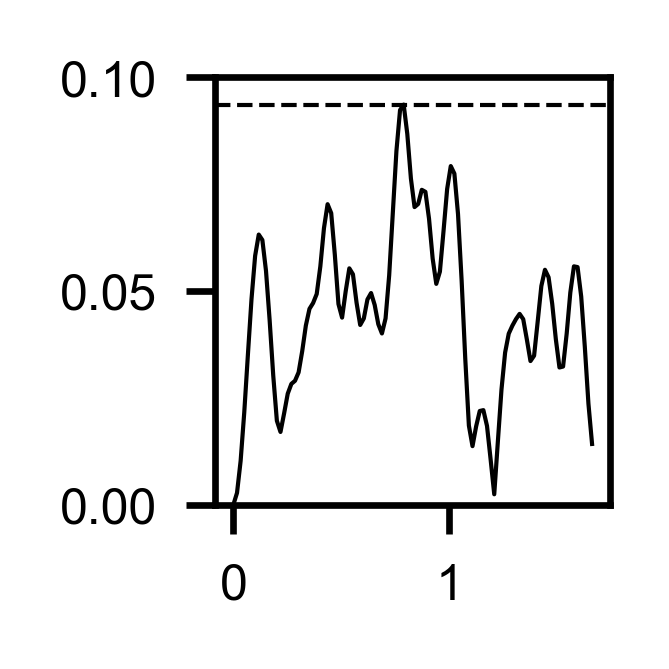

In [18]:
fig, ax = plt.subplots(1, 1, 
                       layout='compressed',
                       figsize=(fig_dim, fig_dim)
                       )
ax.plot(eval_pts, ecf_diff, color='black')
ax.axhline(ecf_diff.max(), linestyle='--', color='black')
ax.set_ylim(0, 0.1)
_ = ax.set_yticks([0.0, 0.05, 0.1])

export_all(fig, 'ecf_compare_tvar_plain')

# EFECT Error per time

In [19]:
def efect_error_over_time(_res1, _res2):
    _result = np.zeros((_res1.shape[0],))
    for _idx in range(_result.shape[0]):
        _ecf1, _ecf2 = compute_ecfs(_res1[_idx, :], _res2[_idx, :])[1:]
        _ecf_diff = compute_ecf_diff(_ecf1, _ecf2)
        _result[_idx] = _ecf_diff.max()
    return _result

ee_t = efect_error_over_time(res_var1, res_var2)

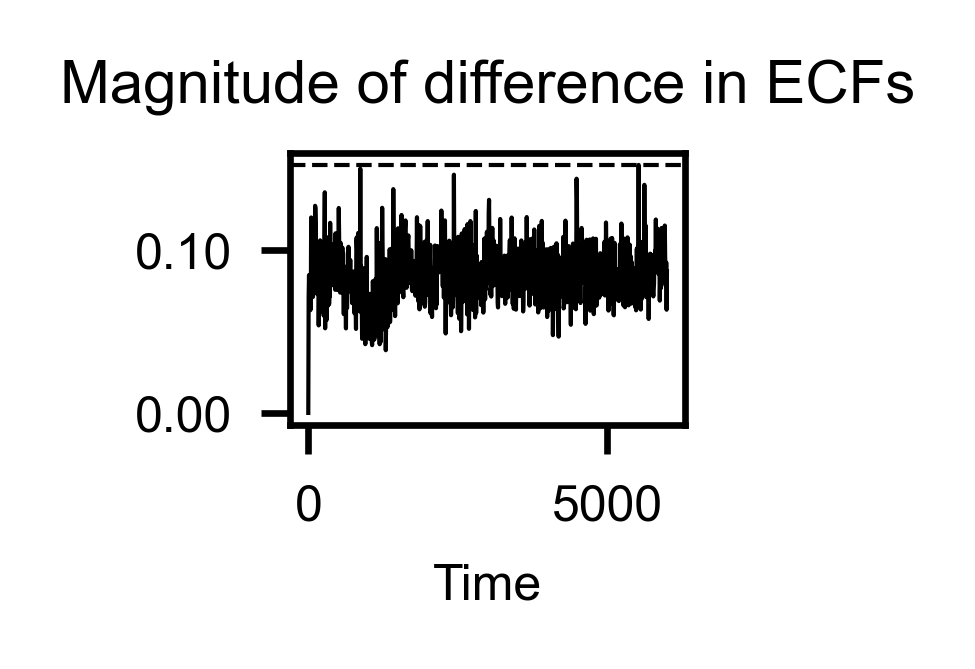

In [20]:
fig, ax = plt.subplots(1, 1, layout='compressed', figsize=(fig_dim, fig_dim))
ax.plot(res_time, ee_t, color='black')
ax.axhline(ee_t.max(), linestyle='--', color='black')
ax.set_xlabel('Time')
ax.set_title('Magnitude of difference in ECFs')
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))

export_all(fig, 'ecf_compare_time')

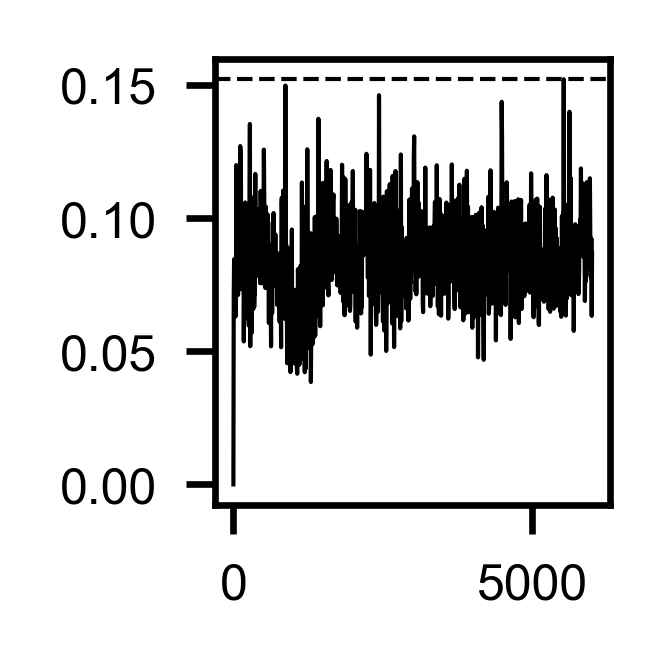

In [21]:
fig, ax = plt.subplots(1, 1, layout='compressed', figsize=(fig_dim, fig_dim))
ax.plot(res_time, ee_t, color='black')
ax.axhline(ee_t.max(), linestyle='--', color='black')
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))

export_all(fig, 'ecf_compare_time_plain')

# Converging EFECT Error vs. sample size

In [22]:
prev_results_fp = 'results/test_231117_0/bistable.json'
prev_efect_errors = []
with open(prev_results_fp, 'r') as f:
    for k, v in json.load(f)['ecf_diff'].items():
        prev_efect_errors.append([int(k), v['y']])

prev_efect_errors = np.asarray(prev_efect_errors)[::2]
prev_efect_errors

array([[1.00000000e+01, 1.52143829e+00],
       [1.00000000e+02, 6.42307016e-01],
       [1.00000000e+03, 1.41785576e-01],
       [1.00000000e+04, 4.41902096e-02]])

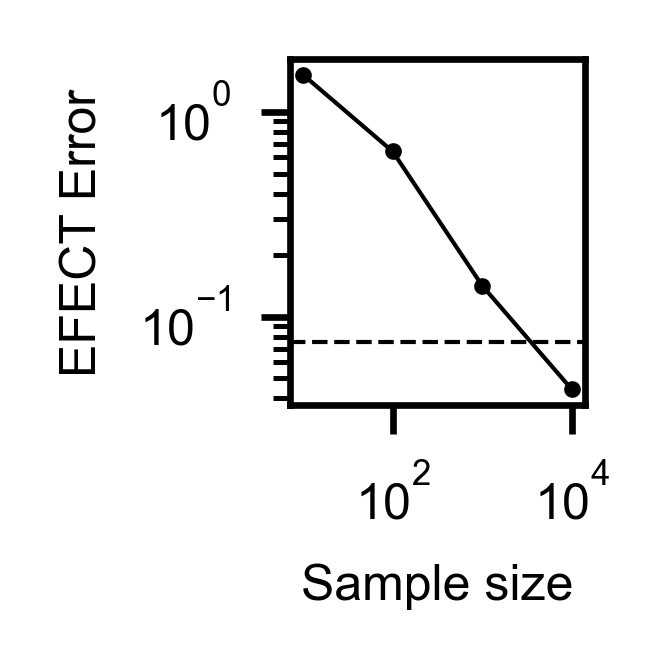

In [23]:
efect_cnv_pt = 0.075

fig, ax = plt.subplots(1, 1, layout='compressed', figsize=(fig_dim, fig_dim))

ax.plot(prev_efect_errors[:, 0].astype(int), prev_efect_errors[:, 1], color='black', marker='o')
ax.axhline(efect_cnv_pt, linestyle='--', color='black')
ax.set_xlabel('Sample size')
ax.set_ylabel('EFECT Error')
ax.set_xscale('log')
ax.set_yscale('log')
if mpl.rcParams['axes.grid']:
    ax.grid(visible=True, which='minor', linewidth=mpl.rcParams['grid.linewidth'] / 2)

export_all(fig, 'error')

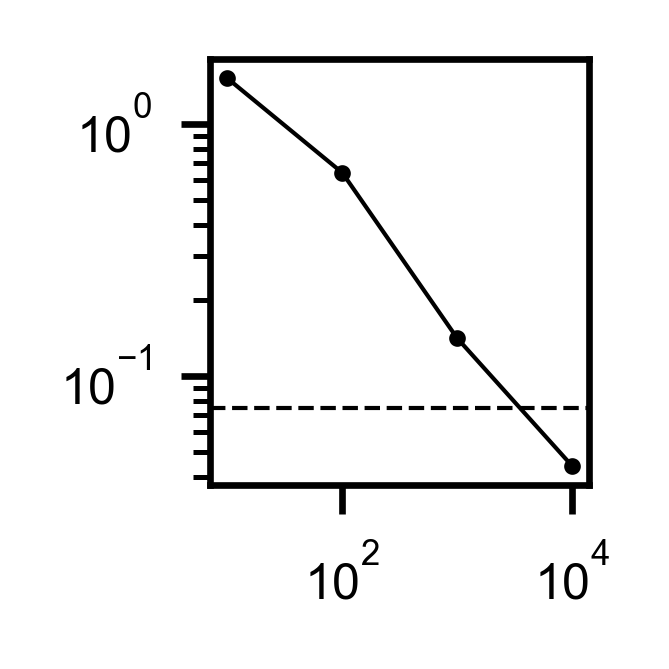

In [24]:
fig, ax = plt.subplots(1, 1, layout='compressed', figsize=(fig_dim, fig_dim))

ax.plot(prev_efect_errors[:, 0].astype(int), prev_efect_errors[:, 1], color='black', marker='o')
ax.axhline(efect_cnv_pt, linestyle='--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
if mpl.rcParams['axes.grid']:
    ax.grid(visible=True, which='minor', linewidth=mpl.rcParams['grid.linewidth'] / 2)

export_all(fig, 'error_plain')